# INF4039 Deep Learning Systems / Giliojo mokymo sistemų taikymai
**LAB6**

## HOMEWORK TASK

Create a Recurrent Neural Network for time series prediction task from one of the following datasets:
1. Predict the Mean monthly number of Sunspots: https://www.kaggle.com/datasets/robervalt/sunspots
2. Number of crimes occuring each day (hour, month, week or other) prediction: https://www.kaggle.com/competitions/sf-crime/data
3. Predict number of Airplane crashes: https://data.world/data-society/airplane-crashes
4. Any other time series (or other type if you feel confident in RNNs) dataset

Your Notebook/script must have the following parts:
1. Data exploration (visualizing data, describing what values will be used for training, what is the target of the prediction, etc.);
2. Data preparation (fill empty values, remove outliers, check the correlations, etc.);
3. Split the data into train and test sets;
4. Neural network - try at least three different structures and see which one is the best for learning;
5. Model evaluation - at least two evaluation methods.

In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [4]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

def plot_timeseries(date, temp):
    # Plot daily median temperatures in Canberra
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=date,
                            y=temp,
                            mode='lines',
                            name='Median Temperature',
                            opacity=0.8,
                            line=dict(color='black', width=1)
                            ))

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Date'
                    )

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Degrees Celsius'
                    )

    # Set figure title
    fig.update_layout(title=dict(text="Median Daily Temperatures in Canberra",
                                font=dict(color='black')))

    fig.show()

## Dataset exploration

For our timeseries data we will be using the Rain in Australia dataset available in Kaggle: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

This dataset contains about 10 years of daily weather observations from numerous Australian weather stations. We are going to predict the temperatures in the Canbarra city.

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/vytkuc/inf4039_2023_autumn/master/lab7_RNN/lab_data.csv')
df

,Date,MedTemp
0,2007-11-01,16.15
1,2007-11-02,20.45
2,2007-11-03,18.55
3,2007-11-04,14.40
4,2007-11-05,11.85
...,...,...
3423,2017-06-21,6.15
3424,2017-06-22,6.75
3425,2017-06-23,5.20
3426,2017-06-24,7.25


In [6]:
plot_timeseries(df.Date, df.MedTemp)

## Data preparation

In [7]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

#data_array = np.array(df.MedTemp.astype('float32'))
X = np.array(df.MedTemp).reshape(-1, 1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.51351351],
       [0.65878378],
       [0.59459459],
       ...,
       [0.14358108],
       [0.21283784],
       [0.1402027 ]])

In [8]:
plot_timeseries(df.Date, X_scaled.reshape(-1))

**DO NOT SHUFFLE IN TIME SERIES!!!**

In [9]:
# Train / Test split (initial only)
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(X_scaled, test_size=0.2, shuffle=False)
print(train_data.shape, test_data.shape)

(2742, 1) (686, 1)


### Reshaping the data
Since we have an array of numbers (a time series object), we need to reshape this array in such a way that we could extract training and testing information.

Hence, we are reshaping the input array so that it would be shaped as: `total_samples x time_steps x features`.

<img src="https://github.com/vytkuc/inf4039_2023_autumn/blob/master/lab7_RNN/img/rnnData.png?raw=1"
     width=750 height=400
     style="display: block; margin: 0 auto"/>

In [10]:
def get_XY(dat, time_steps):
    # Prepare Y
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]

    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))

    return X, Y

time_steps = 7
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [11]:
print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

(391, 7, 1)
(391, 1)
(97, 7, 1)
(97, 1)


In [12]:
train_data[0:21]

array([[0.51351351],
       [0.65878378],
       [0.59459459],
       [0.45439189],
       [0.36824324],
       [0.35810811],
       [0.37837838],
       [0.39527027],
       [0.44594595],
       [0.49493243],
       [0.5472973 ],
       [0.57263514],
       [0.6097973 ],
       [0.69425676],
       [0.66554054],
       [0.71959459],
       [0.72804054],
       [0.6722973 ],
       [0.72297297],
       [0.79560811],
       [0.79054054]])

In [13]:
trainX[0:3]

array([[[0.51351351],
        [0.65878378],
        [0.59459459],
        [0.45439189],
        [0.36824324],
        [0.35810811],
        [0.37837838]],

       [[0.39527027],
        [0.44594595],
        [0.49493243],
        [0.5472973 ],
        [0.57263514],
        [0.6097973 ],
        [0.69425676]],

       [[0.66554054],
        [0.71959459],
        [0.72804054],
        [0.6722973 ],
        [0.72297297],
        [0.79560811],
        [0.79054054]]])

In [14]:
trainY[0:3]

array([[0.39527027],
       [0.66554054],
       [0.57263514]])

## Model definition

<img src="https://github.com/vytkuc/inf4039_2023_autumn/blob/master/lab7_RNN/img/rnnModel.png?raw=1"
     width=1000 height=350
     style="display: block; margin: 0 auto"/>

In [ ]:
!pip install

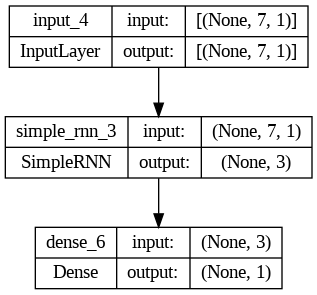

In [19]:
from keras.models import Sequential
from keras import layers

np.random.seed(1330)

from tensorflow.keras.utils import plot_model


def create_model():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(time_steps, 1)),
            layers.SimpleRNN(3, activation = "tanh"),
            layers.Dense(1, activation = "tanh"),
            layers.Dense(1, activation = "linear"),
        ]
    )
    return model

model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)
#model.summary()

In [ ]:
model.compile(loss='mean_squared_error',
              metrics=['MeanSquaredError', 'MeanAbsoluteError'],
              optimizer='adam')

model.fit(trainX,
          trainY,
          batch_size=1,
          epochs=20,
          verbose=0,
          shuffle=True,
         )

In [ ]:
from sklearn.metrics import mean_squared_error

pred_train = model.predict(trainX)
pred_test = model.predict(testX)

print('---------- Evaluation on Training Data ----------')
print("MSE =", mean_squared_error(trainY, pred_train))
print("")

print('---------- Evaluation on Test Data ----------')
print("MSE =", mean_squared_error(testY, pred_test))
print("")

## Plot the predicted results

In [ ]:
def plot_predicted(true_data, pred_data):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.array(range(0,len(true_data))),
                            y=scaler.inverse_transform(true_data).flatten(),
                            mode='lines',
                            name='Median Temperature - Actual (Test)',
                            opacity=0.8,
                            line=dict(color='black', width=1)
                            ))
    fig.add_trace(go.Scatter(x=np.array(range(0,len(pred_data))),
                            y=scaler.inverse_transform(pred_data).flatten(),
                            mode='lines',
                            name='Median Temperature - Predicted (Test)',
                            opacity=0.8,
                            line=dict(color='red', width=1)
                            ))

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Observation'
                    )

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Degrees Celsius'
                    )

    # Set figure title
    fig.update_layout(title=dict(text="Median Daily Temperatures in Canberra",
                                font=dict(color='black')),
                    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                    )

    fig.show()

In [ ]:
plot_predicted(testY, pred_test)